<a href="https://colab.research.google.com/github/connect-midhunr/email-campaign-effectiveness-prediction/blob/main/Email_Campaign_Effectiveness_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Email Campaign Effectiveness Prediction</u></b>

##**Problem Description**

Most of the small to medium business owners are making effective use of Gmail-based e-mail marketing strategies for offline targeting of converting their prospective customers into leads so that they stay with them in business.

The main objective is to create a machine learning model to characterize the mail and track the mail that is ignored; read; acknowledged by the reader.

Data columns are self-explanatory.

# Business Task

Analyse the data on e-mail marketing campaign and build a machine learning model to predict the mail that is ignored, read or acknowledged by the reader.

# Importing Libraries and Defining Functions

In [235]:
# importing all relevant python libraries
import warnings
warnings.filterwarnings("ignore")

import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder

In [236]:
# define a function to find the number and percentage of missing values in a dataframe
def get_missing_values_count_and_percentage(dataframe):
  num = 0
  for column in dataframe.columns:
    count = dataframe[column].isnull().sum()
    percentage = count/dataframe.shape[0]*100
    if percentage > 0:
      num += 1
      print(f"{column}: {count}({round(percentage, 2)})%")
  if num == 0:
    print("No missing values in the dataframe")

In [237]:
# define a function to calculate the vif of all features
# returns a dataframe
def calculate_vif_of_all_features(dataframe):
  temp_df = pd.DataFrame()
  temp_df['Feature'] = dataframe.columns
  temp_df['VIF'] = [variance_inflation_factor(dataframe.values, column_index) for column_index in range(dataframe.shape[1])]

  return temp_df

In [238]:
# define a function to calculate the upper and lower outlier boundary
# returns a tuple (upper_outlier_bound, lower_outlier_bound)
def get_outlier_boundaries(dataframe, column):
  percentile_25 = np.nanpercentile(dataframe[column],25)
  percentile_75 = np.nanpercentile(dataframe[column],75)
  iqr = (percentile_75 - percentile_25)
  upper_outlier_bound = percentile_75 + 1.5*iqr
  lower_outlier_bound = percentile_25 - 1.5*iqr

  return (upper_outlier_bound, lower_outlier_bound)

# define a function to calculate the number and percentage of outliers in a column
# returns a tuple (count, percentage)
def get_outlier_count_and_percentage(dataframe, column):
  # print(dataframe.shape[0])
  upper_outlier_bound, lower_outlier_bound = get_outlier_boundaries(dataframe, column)

  count = 0
  for value in dataframe[column]:
    if value > upper_outlier_bound or value < lower_outlier_bound:
      count += 1
  percentage = round(count/dataframe.shape[0]*100, 2)

  return (count, percentage)

In [239]:
# define a function to generate horizontal box plot
# prints a box plot
def generate_horizontal_box_plot(dataframe, x_feature, y_feature=None):
  sns.set_theme(rc={'figure.figsize': (8,4)},style='whitegrid',palette='muted')
  if y_feature != None:
    ax = sns.boxplot(x=dataframe[x_feature], y=dataframe[y_feature])
  else:
    ax = sns.boxplot(x=dataframe[x_feature], y=None)
  ax.grid(False)

# define a function to generate vertical box plot
# prints a box plot
def generate_vertical_box_plot(dataframe, y_feature, x_feature=None):
  sns.set_theme(rc={'figure.figsize': (4,8)},style='whitegrid',palette='muted')
  if x_feature != None:
    ax = sns.boxplot(y=dataframe[y_feature], x=dataframe[x_feature])
  else:
    ax = sns.boxplot(y=dataframe[y_feature], x=None)
  ax.grid(False)

In [240]:
# get count of each unique value from a particular column 
# and output its as a dataframe
def get_count_from_column(df, column_label):
  df_grpd = df[column_label].value_counts()
  df_grpd = pd.DataFrame({'index':df_grpd.index, 'count':df_grpd.values})
  return df_grpd

# add value to the top of each bar
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1],y_list[i-1], ha="center", fontweight='bold')

# plot bar graph from grouped data
def plot_bar_graph_from_column(df, column_label):
  df_grpd = get_count_from_column(df, column_label)
  
  df_grpd.plot(x='index', y='count', kind='bar', figsize=(3*df_grpd.shape[0], 6))
  add_value_label(df_grpd['index'].tolist(), df_grpd['count'].tolist())
  plt.xlabel(column_label)
  plt.ylabel("Count")
  plt.xticks(rotation='horizontal')
  plt.gca().legend_.remove()
  plt.show()

In [241]:
# generate density plots of a feature in a dataframe
# prints a density plot
def density_plot_of_a_feature(dataframe, feature):
  plt.figure(figsize=(8, 6))
  sns.distplot(dataframe[feature])
  plt.show()

# generate density plots of all features in a dataframe
# prints a density plots
def density_plot_of_all_features(dataframe):
  columns = dataframe.describe().columns.tolist()

  columns_num = 3
  rows_num = math.ceil(len(columns)/columns_num)
  fig, axes = plt.subplots(rows_num, columns_num, figsize=(10*columns_num, 8*rows_num))

  row = -1
  column = columns_num - 1
  for feature in columns:
    if column == (columns_num - 1):
      row += 1
      column = 0
    else:
      column += 1
    sns.distplot(ax=axes[row, column], a=dataframe[feature])
    axes[row, column].set_title(f"{feature} Distribution")
  
  if len(columns) % columns_num != 0:
    for column_num in range(column + 1, columns_num):
      fig.delaxes(axes[rows_num - 1][column_num])

In [242]:
# define a function to plot a stacked bar to show percentage of a feature in a grouped parameter
# so that it can be used in the later stages also

# get the count of unique values in secondary column 
# segmented by each unique value in primary column
def get_count_of_unique_values(df, pri_column_label, sec_column_label):
  # finding unique values in secondary column for grouping
  values = sorted([x for x in df[sec_column_label].unique() if str(x) != 'nan'])

  # creating a list of dataframes that gives the value of each unique value in primary column
  # a dataframe is created for each unique value in secondary column
  list_of_counts_df = [df[df[sec_column_label] == value].groupby(pri_column_label)[sec_column_label].count().reset_index(name=f'{value}')
                       for value in values]
  
  # merge all dataframes into one dataframe
  df_merged = list_of_counts_df[0]
  for i in range(1, len(list_of_counts_df)):
    df_merged = pd.merge(df_merged, list_of_counts_df[i], how='inner', on=pri_column_label)

  return df_merged

# plotting a stacked bar graph to represent the count of unique values in secondary column 
# segmented by each unique value in primary column
def stacked_bar_graph_with_count(df, pri_column_label, sec_column_label):
   # computing the percentage of unique values in secondary column contributed by each unique value in primary column
  df_merged = get_count_of_unique_values(df, pri_column_label, sec_column_label)

  ax = df_merged.plot(x=pri_column_label, kind='bar', stacked=True, figsize=(12,6))
  for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = str(height)
    label_x = x + width / 2
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontweight='bold')
  plt.xticks(rotation='horizontal')
  plt.title(f"Percentage of different categories of {sec_column_label} across each {pri_column_label} category")
  plt.show()

# get the % of unique values in secondary column 
# segmented by each unique value in primary column
def get_percentage_of_unique_values(df, pri_column_label, sec_column_label):
  # finding unique values in secondary column for grouping
  values = [x for x in df[sec_column_label].unique() if str(x) != 'nan']

  # creating a dataframe that gives the count of each unique value in primary column
  df_merged = get_count_of_unique_values(df, pri_column_label, sec_column_label)
  
  # computing the percentage of unique values in secondary column contributed by each unique value in primary column
  df_merged['total_count'] = df_merged.sum(axis=1, numeric_only=True)
  for value in values:
    df_merged[f'{value}'] = round(df_merged[f'{value}'] / df_merged['total_count'] * 100)
  df_merged.drop('total_count', axis=1, inplace=True)
  
  return df_merged

# plotting a stacked bar graph to represent the % of unique values in secondary column 
# segmented by each unique value in primary column
def stacked_bar_graph_with_percentage(df, pri_column_label, sec_column_label):
   # computing the percentage of unique values in secondary column contributed by each unique value in primary column
  df_merged = get_percentage_of_unique_values(df, pri_column_label, sec_column_label)

  ax = df_merged.plot(x=pri_column_label, kind='bar', stacked=True, figsize=(12,6))
  for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    label_text = str(height) + " %"
    label_x = x + width / 2
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontweight='bold')
  plt.xticks(rotation='horizontal')
  plt.title(f"Percentage of different categories of {sec_column_label} across each {pri_column_label} category")
  plt.show()

# Reading Data

In [243]:
# mounting drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [244]:
# creating dataframe and store csv data

campaign_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Supervised Machine Learning - Classification/Email Campaign Effectiveness Prediction - Midhun R/data_email_campaign.csv')

# Data Inspection

The given data contains information regarding the mails sent as a part of Gmail-based e-mail marketing campaign. Lets first examine the data present in it.

In [245]:
# exploring the head of the dataframe
campaign_df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33.0,1,440,8.0,0.0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15.0,2,504,5.0,0.0,0
2,EMA00081000066290,2,0.1,1,B,3,36.0,2,962,5.0,0.0,1
3,EMA00081000076560,1,3.0,2,E,2,25.0,2,610,16.0,0.0,0
4,EMA00081000109720,1,0.0,2,C,3,18.0,2,947,4.0,0.0,0


In [246]:
# exploring the tail of the dataframe
campaign_df.tail()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
68348,EMA00089995974500,2,0.4,1,F,2,22.0,3,737,16.0,13.0,0
68349,EMA00089998225300,1,1.3,1,C,2,40.0,2,653,31.0,16.0,0
68350,EMA00089998436500,1,2.2,2,NaN,2,33.0,2,490,9.0,0.0,0
68351,EMA00089999168800,1,0.4,1,E,2,50.0,1,733,14.0,4.0,0
68352,EMA00089999316900,1,1.5,1,G,2,20.0,2,1038,6.0,0.0,0


In [247]:
# looking into a brief summary of dataframe
campaign_df.describe()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
count,68353.000000,68353.000000,68353.000000,68353.000000,61528.000000,68353.000000,68353.000000,66152.000000,66676.000000,68353.000000
mean,1.285094,1.095481,1.456513,2.272234,28.933250,1.999298,699.931751,10.429526,3.550678,0.230934
std,0.451462,0.997578,0.498109,0.468680,12.536518,0.631103,271.719440,6.383270,5.596983,0.497032
min,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,40.000000,1.000000,0.000000,0.000000
25%,1.000000,0.200000,1.000000,2.000000,20.000000,2.000000,521.000000,6.000000,0.000000,0.000000
50%,1.000000,0.800000,1.000000,2.000000,28.000000,2.000000,694.000000,9.000000,0.000000,0.000000
75%,2.000000,1.800000,2.000000,3.000000,38.000000,2.000000,880.000000,14.000000,5.000000,0.000000
max,2.000000,5.000000,2.000000,3.000000,67.000000,3.000000,1316.000000,49.000000,45.000000,2.000000


In [248]:
# total number of rows in the dataset
num_of_rows = campaign_df.shape[0]
print(f"Total no. of rows: {num_of_rows}")

# number of duplicate rows
num_of_dup_rows = campaign_df[campaign_df.duplicated()].shape[0]
print(f"No. of duplicate rows: {num_of_dup_rows}")

Total no. of rows: 68353
No. of duplicate rows: 0


*   The dataframe contains 68353 rows of data and has zero duplicate rows.

In [249]:
# exploring the columns of the dataframe
campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68353 entries, 0 to 68352
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Email_ID                   68353 non-null  object 
 1   Email_Type                 68353 non-null  int64  
 2   Subject_Hotness_Score      68353 non-null  float64
 3   Email_Source_Type          68353 non-null  int64  
 4   Customer_Location          56758 non-null  object 
 5   Email_Campaign_Type        68353 non-null  int64  
 6   Total_Past_Communications  61528 non-null  float64
 7   Time_Email_sent_Category   68353 non-null  int64  
 8   Word_Count                 68353 non-null  int64  
 9   Total_Links                66152 non-null  float64
 10  Total_Images               66676 non-null  float64
 11  Email_Status               68353 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 6.3+ MB


*   The dataframe contains 12 columns.
*   Four columns have missing values.
*   Three columns require conversion of datatypes. 

In [250]:
# unique values in each column of the dataframe
print(campaign_df.apply(lambda col: col.unique()))

Email_ID                     [EMA00081000034500, EMA00081000045360, EMA0008...
Email_Type                                                              [1, 2]
Subject_Hotness_Score        [2.2, 2.1, 0.1, 3.0, 0.0, 1.5, 3.2, 0.7, 2.0, ...
Email_Source_Type                                                       [2, 1]
Customer_Location                                   [E, nan, B, C, G, D, F, A]
Email_Campaign_Type                                                  [2, 3, 1]
Total_Past_Communications    [33.0, 15.0, 36.0, 25.0, 18.0, nan, 34.0, 21.0...
Time_Email_sent_Category                                             [1, 2, 3]
Word_Count                   [440, 504, 962, 610, 947, 416, 116, 1241, 655,...
Total_Links                  [8.0, 5.0, 16.0, 4.0, 11.0, 6.0, 21.0, nan, 31...
Total_Images                 [0.0, 2.0, 4.0, 16.0, 13.0, 15.0, 5.0, 28.0, 1...
Email_Status                                                         [0, 1, 2]
dtype: object


The columns and the data it represents are listed below:

1. **Email_ID** : E-mail ID of recipients.

2. **Email_Type** : Differentiates between 2 different e-mail types: 1 and 2.

3. **Subject_Hotness_Score** : Measures the strength and effectiveness of mail subject.

4. **Email_Source_Type** : Differentiates between 2 different e-mail source types: 1 and 2.

5. **Customer_Location** : Differentiates between 7 different e-mail customer locations: A, B, C, D, E, F and G.

6. **Email_Campaign_Type** : Differentiates between 3 different e-mail campaign types: 1, 2 and 3.

7. **Total_Past_Communications** : Number of previous communications from the same source.

8. **Time_Email_sent_Category** : Differentiates between 3 different time of day (the mail was sent) category: 1, 2 and 3.

9. **Word_Count** : Number of words in the mail.

10. **Total_Links** : Number of links in the mail.

11. **Total_Images** : Number of images in the mail.

12. **Email_Status** : Differentiates between 3 different e-mail statuses: 1, 2 and 3, representing ignored, read & acknowledged respectively. This is our target variable.

# Data Cleaning

### Handle Missing Values

Four out of 12 columns in store data have missing values in them. They must be handled properly inorder to get an accurate result.

In [251]:
# finding the number and percentage of missing values in the store data
get_missing_values_count_and_percentage(campaign_df)

Customer_Location: 11595(16.96)%
Total_Past_Communications: 6825(9.98)%
Total_Links: 2201(3.22)%
Total_Images: 1677(2.45)%


Customer_Location is a categorical feature but it cannot be blindly imputed with its mode since a large number of observations have missing values in it. We cannot remove this column or these observations as it will lead to a loss of information. None of the other features has any possibility of causing some effect on customer location or vice versa. So, it is difficult to find a value to impute in relation to other features. 

For now, we will skip this and later decide how to handle the missing values after we get a clear picture about the correlation between Customer_Location and Email_Status.

Total_Past_Communications is a numerical feature. Lets check its density plot to choose the value we need to impute missing values.

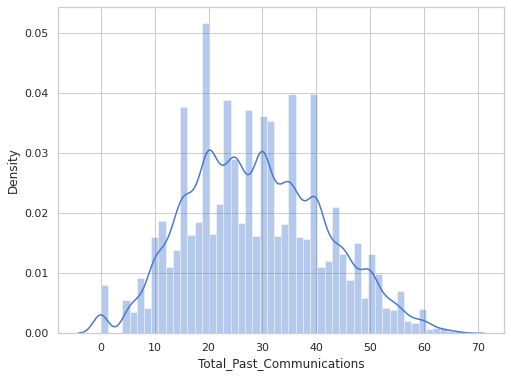

In [252]:
# create a density plot to show the distribution of values in Total_Past_Communications

density_plot_of_a_feature(campaign_df, 'Total_Past_Communications')

Total_Past_Communications has an almost normal distribution. So, mean or median can be used to impute missing values. But before that we need to check whether some other important features affect its values since a large number of observations have missing values in it.

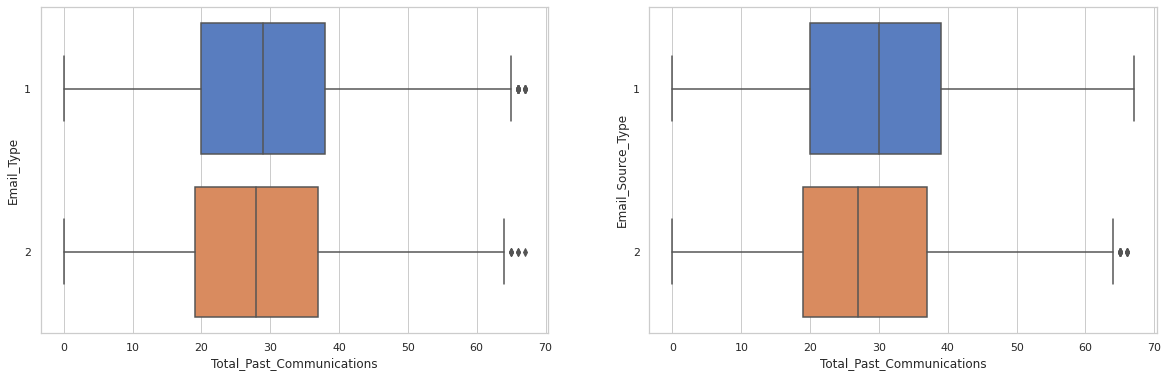

In [253]:
# generate box plots to show the distribution of Total_Past_Communications in each category of Email_Type and Email_Source_Type

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(ax=axes[0], data=campaign_df, x='Total_Past_Communications', y='Email_Type', orient='h')
sns.boxplot(ax=axes[1], data=campaign_df, x='Total_Past_Communications', y='Email_Source_Type', orient='h')

Lets check its box plot to check for outliers.

Number of outliers: 27
Percentage of outliers: 0.04%


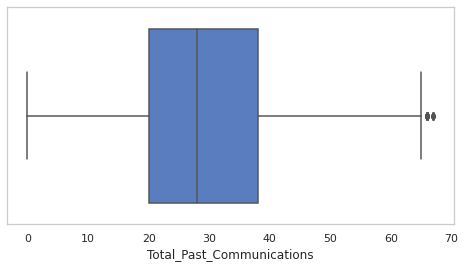

In [254]:
# create a box plot to show the distribution of values in Total_Past_Communications

generate_horizontal_box_plot(campaign_df, 'Total_Past_Communications')
outlier_count, outlier_percentage = get_outlier_count_and_percentage(campaign_df, 'Total_Past_Communications')
print(f"Number of outliers: {outlier_count}")
print(f"Percentage of outliers: {outlier_percentage}%")

It has very less outliers. So we can impute the missing values with its mean.

In [255]:
# filling the missing values with mean
campaign_df["Total_Past_Communications"].fillna(value = campaign_df.Total_Past_Communications.mean(), inplace=True)

Total_Links is also a numerical feature. Lets check its density plot to choose the value we need to impute missing values.

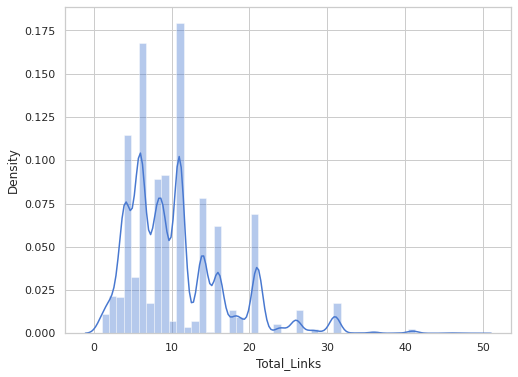

In [256]:
# create a density plot to show the distribution of values in Total_Links

density_plot_of_a_feature(campaign_df, 'Total_Links')

The distribution of Total_Links is positively skewed. Since only a small number of observations have missing values in it, checking for the influence of other features is not necessary and it is safe to impute missing values with mode or median. Mean can be avoided as it has outliers. Since the PDF of the peak of the distribution is very low, it is better to go with median instead of mode.

In [257]:
# filling the missing values with median
campaign_df["Total_Links"].fillna(value = campaign_df.Total_Links.median(), inplace=True)

Total_Images is again a numerical feature. Lets check its density plot to choose the value we need to impute missing values.

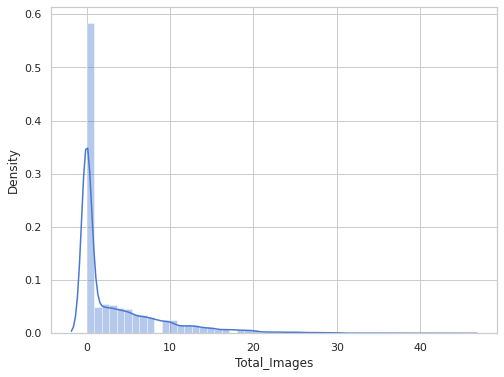

In [258]:
# create a density plot to show the distribution of values in Total_Links

density_plot_of_a_feature(campaign_df, 'Total_Images')

The distribution of Total_Images is positively skewed. Since only a small number of observations have missing values in it, it is safe to impute missing values with mode or median. Since the peak of the distribution has high PDF, mode can be chosen over median.

In [259]:
# filling the missing values with mode
campaign_df["Total_Images"].fillna(value = campaign_df.Total_Images.mode()[0], inplace=True)

In [260]:
# number and percentage of missing values in the dataframe
get_missing_values_count_and_percentage(campaign_df)

Customer_Location: 11595(16.96)%


### Conversion of Column Datatype

In [261]:
# datatypes of columns in the dataframe
campaign_df.dtypes

Email_ID                      object
Email_Type                     int64
Subject_Hotness_Score        float64
Email_Source_Type              int64
Customer_Location             object
Email_Campaign_Type            int64
Total_Past_Communications    float64
Time_Email_sent_Category       int64
Word_Count                     int64
Total_Links                  float64
Total_Images                 float64
Email_Status                   int64
dtype: object

In [262]:
# convert Total_Past_Communications, Total_Links, Total_Images
# from float to int
campaign_df = campaign_df.astype({"Total_Past_Communications":int, "Total_Links":int, "Total_Images":int})

In [263]:
# datatypes of columns in the dataframe
campaign_df.dtypes

Email_ID                      object
Email_Type                     int64
Subject_Hotness_Score        float64
Email_Source_Type              int64
Customer_Location             object
Email_Campaign_Type            int64
Total_Past_Communications      int64
Time_Email_sent_Category       int64
Word_Count                     int64
Total_Links                    int64
Total_Images                   int64
Email_Status                   int64
dtype: object

# Exploratory Data Analysis

First lets check whether our dataset is balanced or not. 

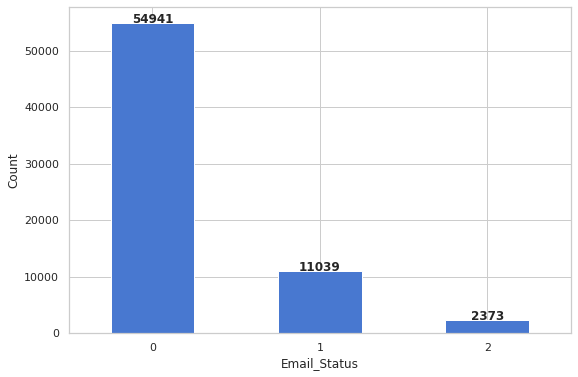

In [95]:
# plot bar graph to show the count of each category in Email_Status

plot_bar_graph_from_column(campaign_df, 'Email_Status')

It is observed that Email_Status 0 has more than 4 times the observations than rest of them combined. So, the dataset set is highly imbalanced and Email_Status 0 is the majority class and the rest of them are minority classes.

Lets check out the distribution of all the features.

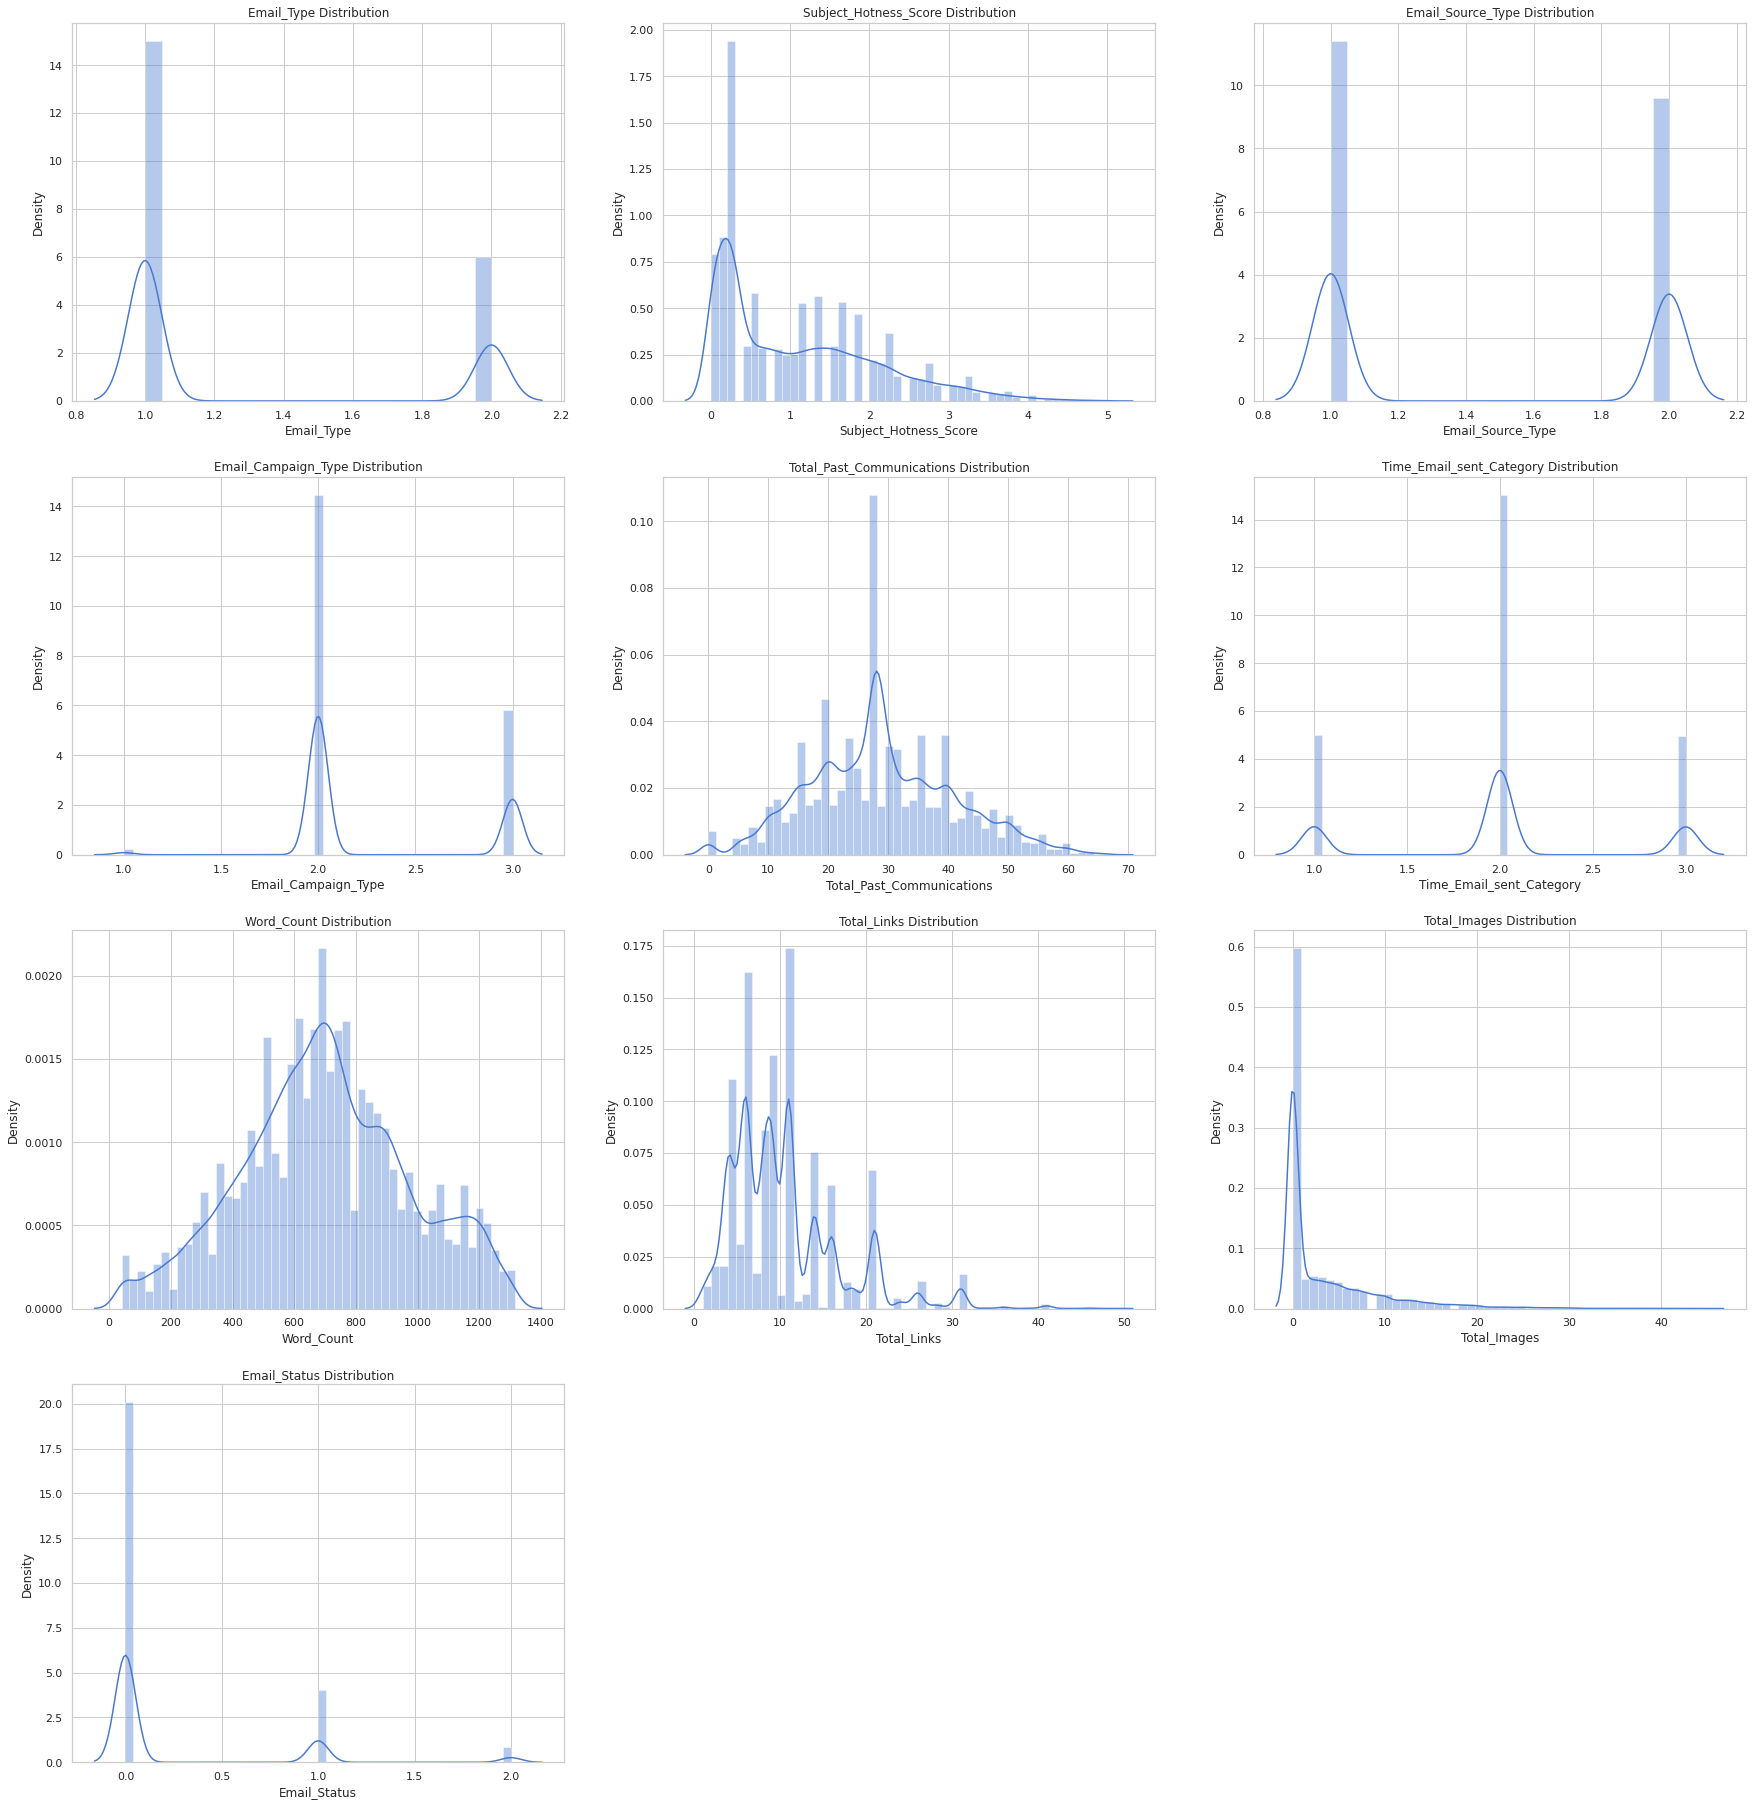

In [28]:
# plot the distribution of all features
density_plot_of_all_features(campaign_df)

Subject_Hotness_Score, Total_Links and Total_Images are positively skewed while Total_Past_Communications and Word_Count are almost normally distributed. All other features are categorical.

Lets check how categorical features influence the Email_Status.

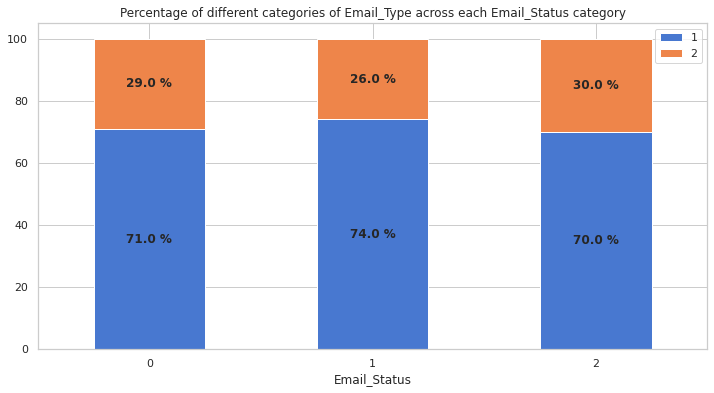

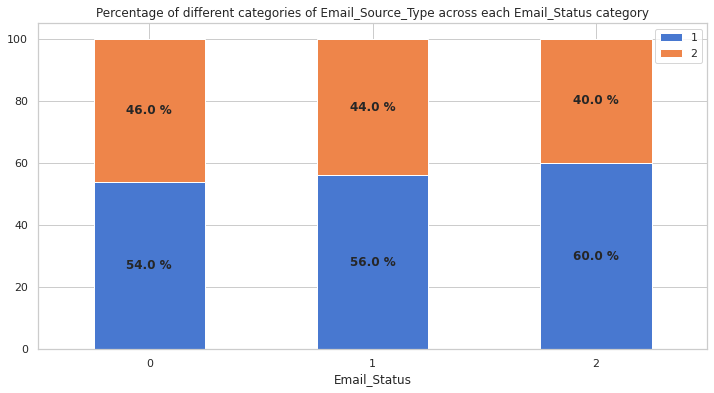

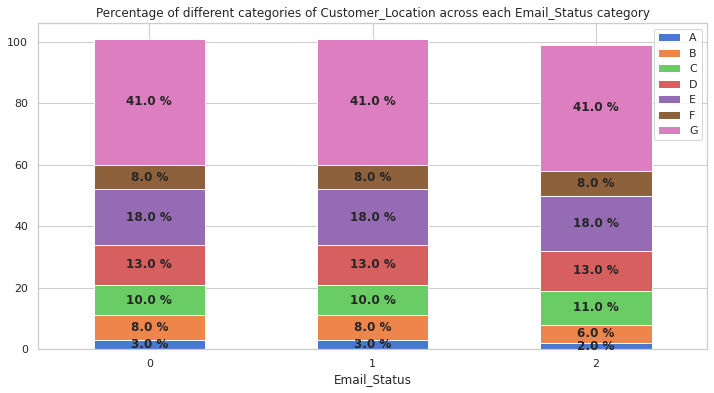

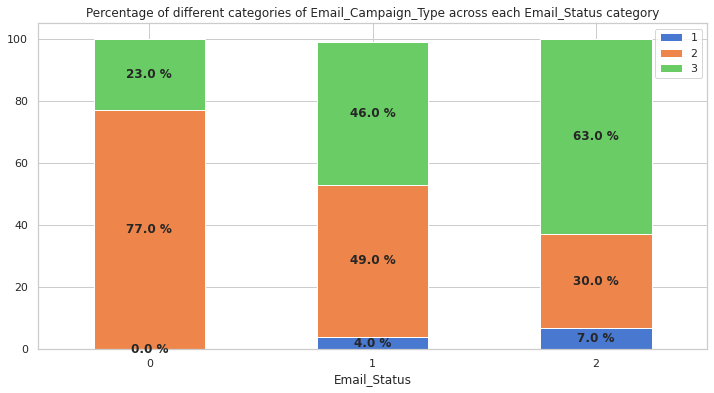

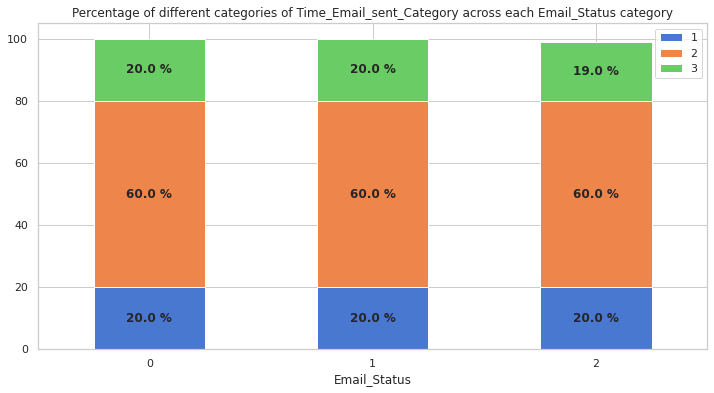

In [29]:
# plot stacked bar graphs to show the percentage of e-mails in each feature category for every Email_Status
categorical_features = ['Email_Type', 'Email_Source_Type', 'Customer_Location', 
                        'Email_Campaign_Type', 'Time_Email_sent_Category']

for feature in categorical_features:
  stacked_bar_graph_with_percentage(campaign_df, 'Email_Status', feature)

We can see that all categories of a feature have same distribution of e-mails across each category of Email_Status.

Email_Campaign_Type is the only feature which does not follow this trend. So it has the most impact on the target feature. If Email_Campaign_Type is 1, then the mail has 66% chance of getting read and 23% change of getting acknowledged.

Lets check how numerical features influence the Email_Status.

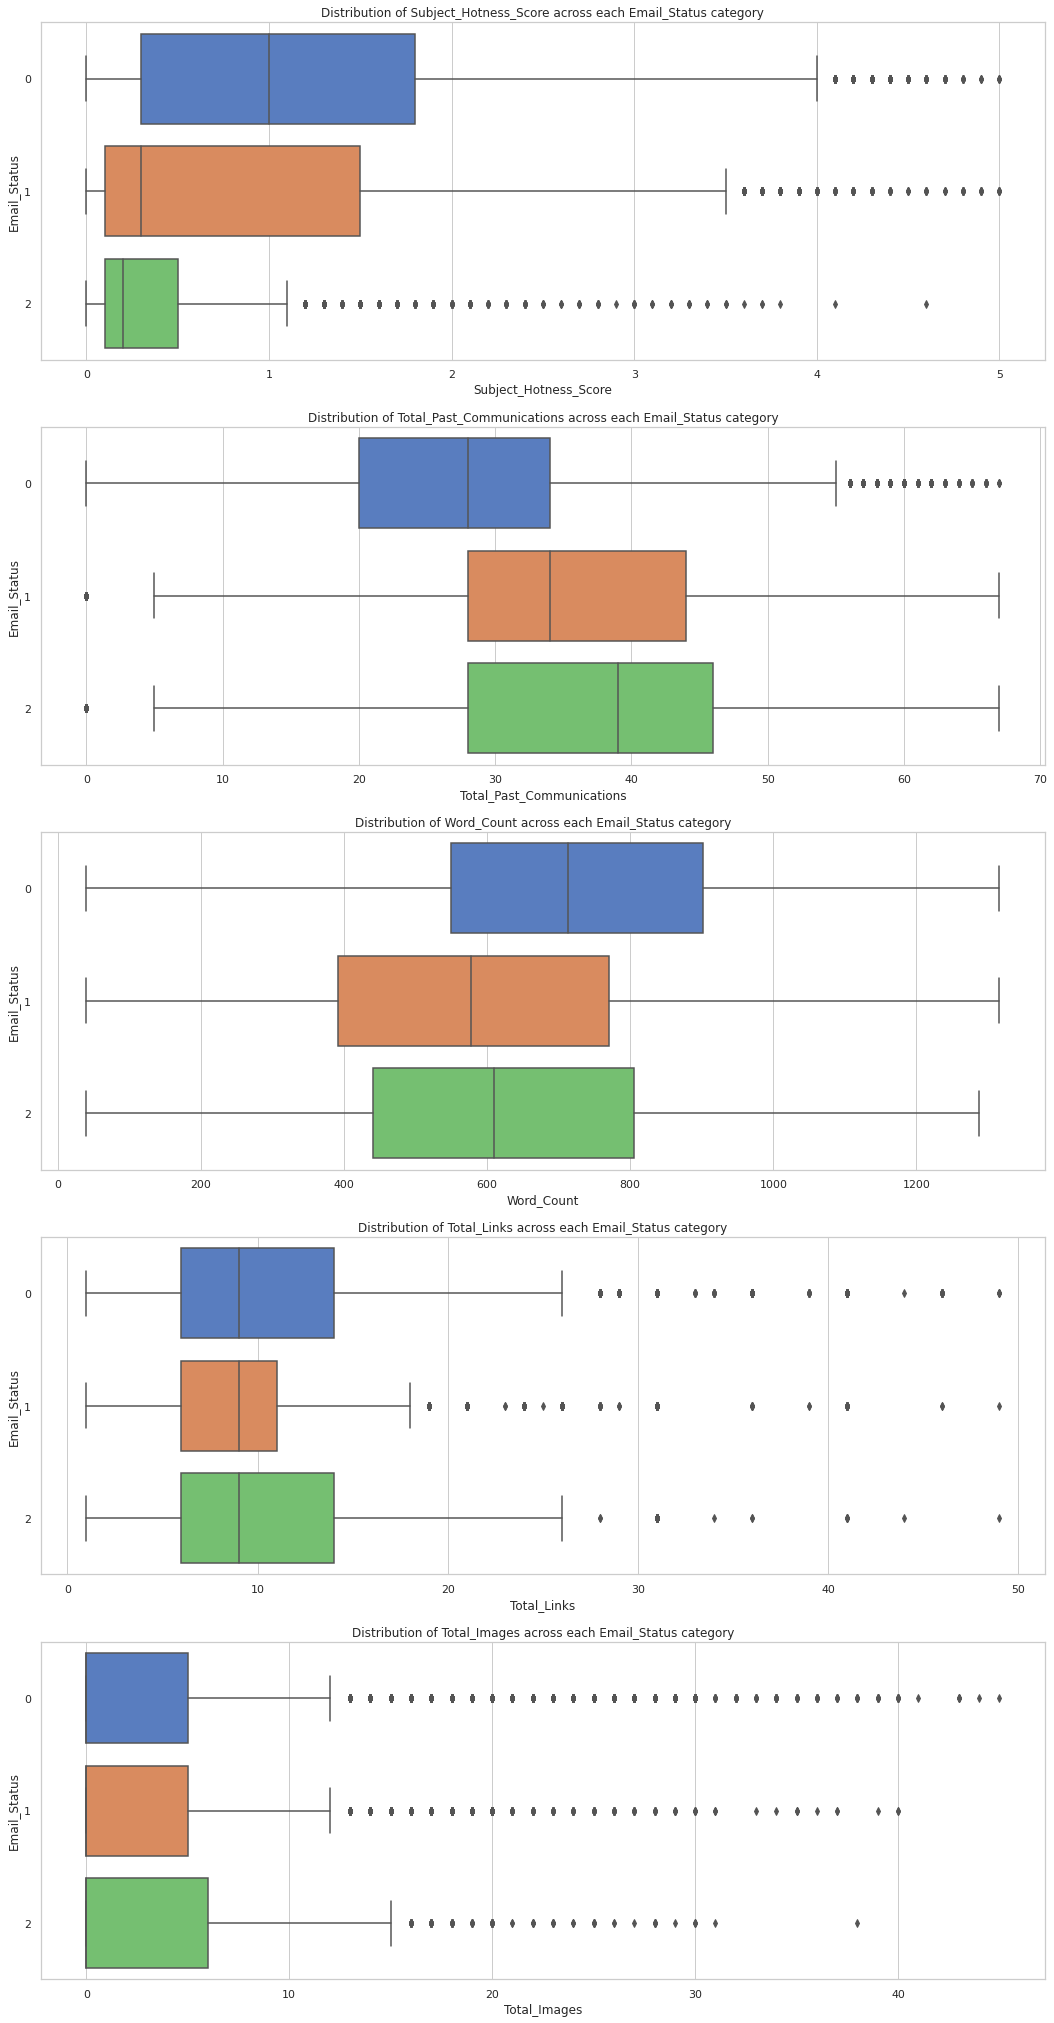

In [30]:
# generate box plots to show the distribution of numerical features in each category of Email_Status
numerical_features = ['Subject_Hotness_Score', 'Total_Past_Communications', 
                      'Word_Count', 'Total_Links', 'Total_Images']

fig, axes = plt.subplots(5, 1, figsize=(18, 36))

for row, feature in enumerate(numerical_features):
  sns.boxplot(ax=axes[row], data=campaign_df, x=feature, y='Email_Status', orient='h')
  axes[row].set_title(f"Distribution of {feature} across each Email_Status category")

*   As the subject hotness score increases, probability of mails getting acknowledged decreases. There is a good chance of getting e-mails read or acknowledge if the subject hotness score is less than 5.
*   As the number of total past communications increases, probability of mails getting acknowledged or read also increases. There is a high chance of getting e-mails read or acknowledge if the number of total past communications is greater than 25.
*   As the word count increases, probability of mails getting ignored also increases. There is a high chance of getting e-mails read or acknowledge if the the word count is between 400 and 600.
*   The total number of links have similar distribution across each Email_Status category but read mails have slightly less variance than others.
*   The total number of images have similar distribution across each Email_Status category but acknowledged mails have slightly more variance than others.


Lets visualize the relationship between various features using correlation heat map.

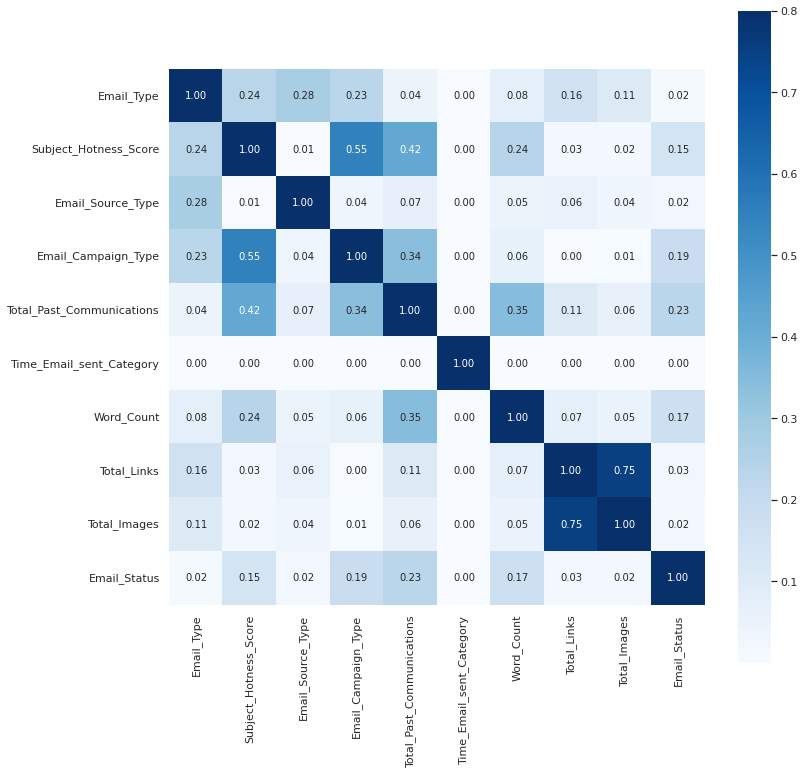

In [31]:
# generate a correlation matrix using all features in the dataframe
corr_mat = campaign_df.corr().abs()

# plot heatmap using correlation matrix
fig, axes = plt.subplots(figsize=(12, 12))
sns.heatmap(corr_mat, annot = True, fmt='.2f', annot_kws={'size': 10},  vmax=.8, square=True, cmap='Blues');

*   Time_Email_sent_Category has no correlation with Email_Status or any of the other independant features.
*   Email_Campaign_Type and Total_Past_Communications have the most positive correlation.
*   Subject_Hotness_Score and Word_Count have the most negative correlation.
*   Multicollinearity can be observed between Subject_Hotness_Score, Email_Campaign_Type & Total_Past_Communications and Total_Links & Total_Images.

# Feature Engineering

In [264]:
# exploring the head of the dataframe
campaign_df.head()

,Email_ID,Email_Type,Subject_Hotness_Score,Email_Source_Type,Customer_Location,Email_Campaign_Type,Total_Past_Communications,Time_Email_sent_Category,Word_Count,Total_Links,Total_Images,Email_Status
0,EMA00081000034500,1,2.2,2,E,2,33,1,440,8,0,0
1,EMA00081000045360,2,2.1,1,NaN,2,15,2,504,5,0,0
2,EMA00081000066290,2,0.1,1,B,3,36,2,962,5,0,1
3,EMA00081000076560,1,3.0,2,E,2,25,2,610,16,0,0
4,EMA00081000109720,1,0.0,2,C,3,18,2,947,4,0,0


## Feature Selection

Lets remove Email_ID since it does not affect the status of e-mail.

In [265]:
campaign_df.drop('Email_ID', axis=1, inplace=True)

Lets remove Customer_Location since it has a lot of missing values which cannot be easily imputed and also it does not have much impact on the target variable as all the locations have same probability of  mails getting ignored, read and acknowledged.

In [266]:
# drop Customer_Location
campaign_df.drop('Customer_Location', axis=1, inplace=True)

Lets remove Time_Email_sent_Category as we have already established in EDA that its has no correlation to any features and therefore so it doesn't affect the mail status.

In [267]:
# drop Time_Email_sent_Category
campaign_df.drop('Time_Email_sent_Category', axis=1, inplace=True)

In [268]:
# exploring the head of the dataframe
campaign_df.head()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Word_Count,Total_Links,Total_Images,Email_Status
0,1,2.2,2,2,33,440,8,0,0
1,2,2.1,1,2,15,504,5,0,0
2,2,0.1,1,3,36,962,5,0,1
3,1,3.0,2,2,25,610,16,0,0
4,1,0.0,2,3,18,947,4,0,0


## Handling Multicollinearity

Lets find out the VIF of all numerical features in order to remove highly correlated features. Features having VIF greater than 5 should be eliminated.

In [269]:
# calculate VIF of all numerical features
numerical_independant_features = ['Subject_Hotness_Score', 'Total_Past_Communications', 'Word_Count', 'Total_Links', 'Total_Images']
calculate_vif_of_all_features(campaign_df[[column for column in campaign_df.describe().columns if column in numerical_independant_features]])

,Feature,VIF
0,Subject_Hotness_Score,1.803914
1,Total_Past_Communications,3.911830
2,Word_Count,4.047726
3,Total_Links,8.581007
4,Total_Images,3.162623


The only feature with VIF greater than 5 is Total_Links. But we cannot just remove this from our dataset because it is an important feature.
From what we have observed in EDA, Total_Links and Total_Images have good a correlation. So lets combine these two features into a new feature.

In [270]:
# create a new feature by combining Total_Links & Total_Images
campaign_df['Total_Links_Images'] = campaign_df['Total_Links'] + campaign_df['Total_Images']
campaign_df.drop(['Total_Links', 'Total_Images'], axis=1, inplace=True)

In [271]:
numerical_independant_features.remove('Total_Links')
numerical_independant_features.remove('Total_Images')
numerical_independant_features.append('Total_Links_Images')

In [272]:
# exploring the head of the dataframe
campaign_df.head()

,Email_Type,Subject_Hotness_Score,Email_Source_Type,Email_Campaign_Type,Total_Past_Communications,Word_Count,Email_Status,Total_Links_Images
0,1,2.2,2,2,33,440,0,8
1,2,2.1,1,2,15,504,0,5
2,2,0.1,1,3,36,962,1,5
3,1,3.0,2,2,25,610,0,16
4,1,0.0,2,3,18,947,0,4


In [273]:
# calculate VIF of all numerical features
calculate_vif_of_all_features(campaign_df[[column for column in campaign_df.describe().columns if column in numerical_independant_features]])

,Feature,VIF
0,Subject_Hotness_Score,1.733962
1,Total_Past_Communications,3.417183
2,Word_Count,3.678383
3,Total_Links_Images,2.613952


Now, all features have VIF below 5.

## Handling Outliers

### Subject Hotness Score

Lets check for outliers in Subject_Hotness_Score using a box plot.

Outliers in Subject_Hotness_Score : 247 (0.36%)


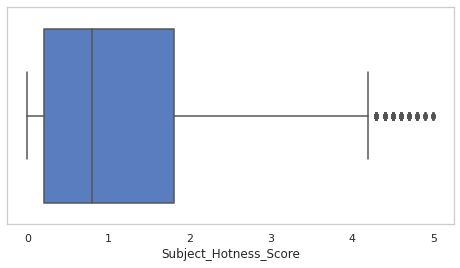

In [274]:
# generate a box plot for Subject_Hotness_Score
generate_horizontal_box_plot(campaign_df, 'Subject_Hotness_Score')

# count and percentage of outliers in Subject_Hotness_Score
count, perc = get_outlier_count_and_percentage(campaign_df, 'Subject_Hotness_Score')
print(f"Outliers in Subject_Hotness_Score : {count} ({perc}%)")

This is a very small portion of the data. Lets remove them.

In [275]:
# remove outliers
upper_boundary, lower_boundary = get_outlier_boundaries(campaign_df, 'Subject_Hotness_Score')
campaign_df = campaign_df[(campaign_df['Subject_Hotness_Score'] > lower_boundary) & (campaign_df['Subject_Hotness_Score'] < (upper_boundary-0.2))]

### Total Past Communications

Lets check for outliers in Total_Past_Communications using a box plot.

Outliers in Total_Past_Communications : 136 (0.2%)


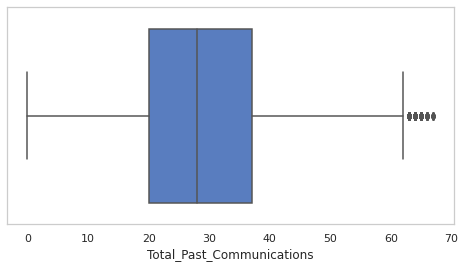

In [276]:
# generate a box plot for Total_Past_Communications
generate_horizontal_box_plot(campaign_df, 'Total_Past_Communications')

# count and percentage of outliers in Total_Past_Communications
count, perc = get_outlier_count_and_percentage(campaign_df, 'Total_Past_Communications')
print(f"Outliers in Total_Past_Communications : {count} ({perc}%)")

This is a very small portion of the data. Lets remove them.

In [277]:
# remove outliers
upper_boundary, lower_boundary = get_outlier_boundaries(campaign_df, 'Total_Past_Communications')
campaign_df = campaign_df[(campaign_df['Total_Past_Communications'] > lower_boundary) & (campaign_df['Total_Past_Communications'] < (upper_boundary-0.2))]

### Word Count

Lets check for outliers in Word_Count using a box plot.

Outliers in Word_Count : 0 (0.0%)


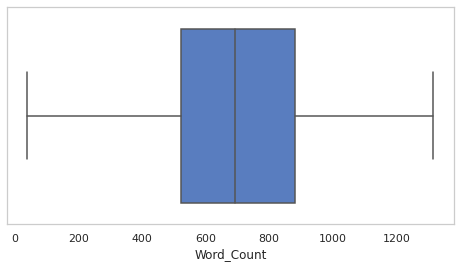

In [278]:
# generate a box plot for Word_Count
generate_horizontal_box_plot(campaign_df, 'Word_Count')

# count and percentage of outliers in Word_Count
count, perc = get_outlier_count_and_percentage(campaign_df, 'Word_Count')
print(f"Outliers in Word_Count : {count} ({perc}%)")

There are no outliers in Word_Count

### Total Links & Images

Lets check for outliers in Total_Links_Images using a box plot.

Outliers in Total_Links_Images : 3594 (5.31%)


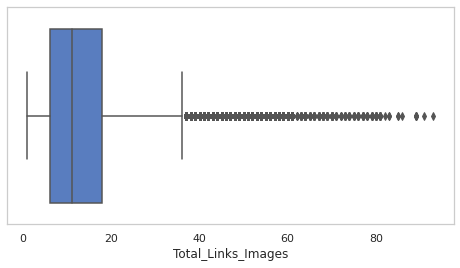

In [279]:
# generate a box plot for Total_Links_Images
generate_horizontal_box_plot(campaign_df, 'Total_Links_Images')

# count and percentage of outliers in Total_Links_Images
count, perc = get_outlier_count_and_percentage(campaign_df, 'Total_Links_Images')
print(f"Outliers in Total_Links_Images : {count} ({perc}%)")

It can be seen that Total_Links_Images has a large number of outliers, which may cause loss of information. But it is acceptable if there is only less than 5% outliers in minority classes.

Lets find out the percentage of outliers in majority and minority classes.

Outliers in Total_Links_Images : 3043 (5.59%)


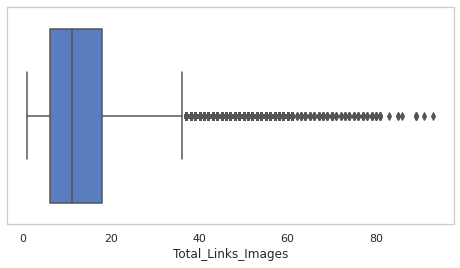

In [280]:
# generate a box plot for Total_Links_Images in majority class
generate_horizontal_box_plot(campaign_df[campaign_df['Email_Status'] == 0], 'Total_Links_Images')

# count and percentage of outliers in Total_Links_Images in majority class
count, perc = get_outlier_count_and_percentage(campaign_df[campaign_df['Email_Status'] == 0], 'Total_Links_Images')
print(f"Outliers in Total_Links_Images : {count} ({perc}%)")

Outliers in Total_Links_Images : 721 (5.46%)


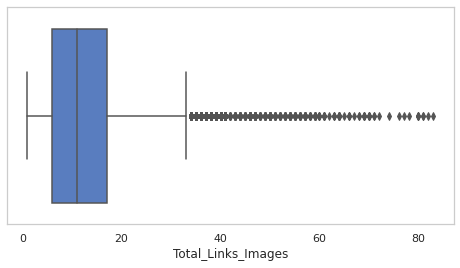

In [281]:
# generate a box plot for Total_Links_Images in minority classes
generate_horizontal_box_plot(campaign_df[(campaign_df['Email_Status'] == 1) | (campaign_df['Email_Status'] == 2)], 'Total_Links_Images')

# count and percentage of outliers in Total_Links_Images in minority classes
count, perc = get_outlier_count_and_percentage(campaign_df[(campaign_df['Email_Status'] == 1) | (campaign_df['Email_Status'] == 2)], 'Total_Links_Images')
print(f"Outliers in Total_Links_Images : {count} ({perc}%)")

The percentage of outliers in minority classes is above 5. So, it is better to not remove them.

## Feature Transformation

Transformation of numerical features is important because algorithms based on gradient descent and distance performs better when features are close to Normal Distribution.

Lets check whether all important numerical features have a normal distribution.

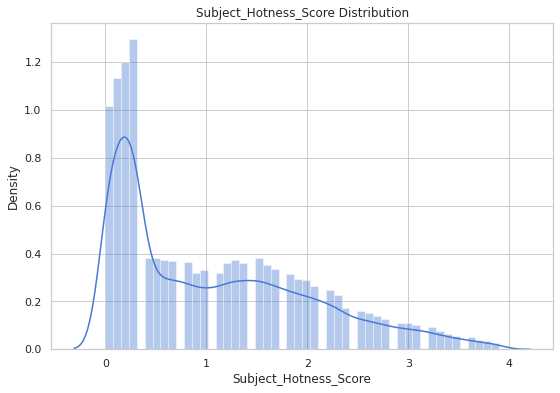

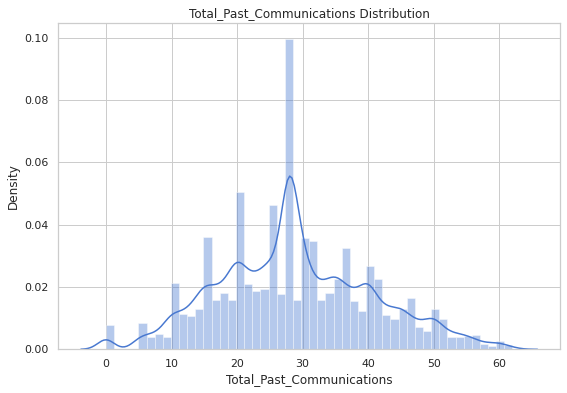

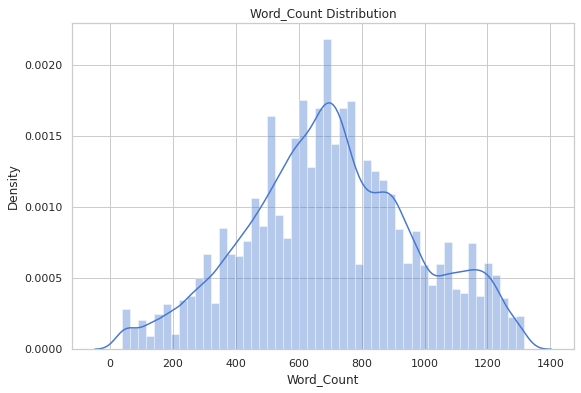

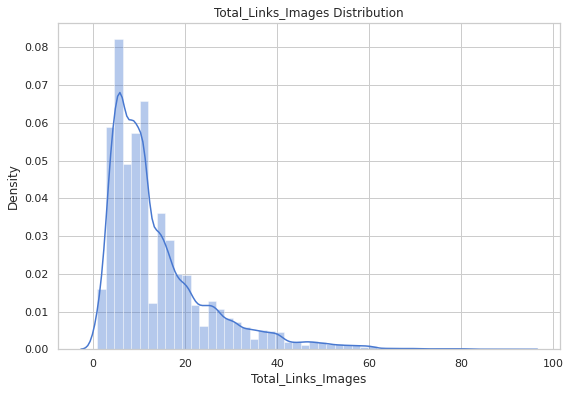

In [282]:
# numerical features
numerical_features = ['Subject_Hotness_Score', 'Total_Past_Communications', 'Word_Count', 'Total_Links_Images']

# generate density plot for numerical features
for feature in numerical_features:
  plt.figure(figsize=(9, 6))
  sns.distplot(campaign_df[feature]).set(title=f'{feature} Distribution')
  plt.show()

Subject_Hotness_Score and Total_Links_Images are positively skewed. So, they must be transformed to normal distribution. 

Subject_Hotness_Score has zero values while Total_Links_Images has only positive values. So Subject_Hotness_Score is square root transformed and Total_Links_Images is log transformed.

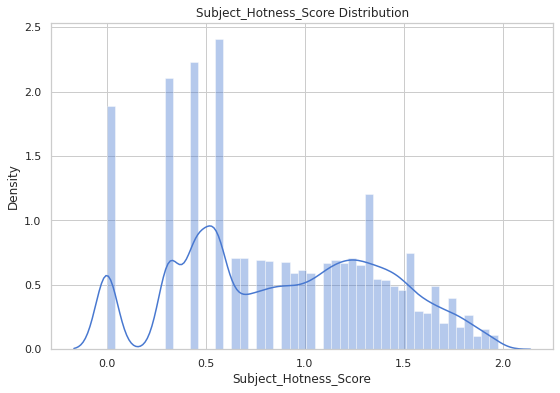

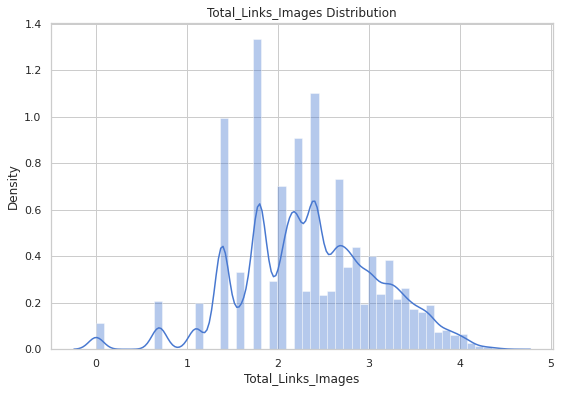

In [283]:
campaign_df['Subject_Hotness_Score'] = np.sqrt(campaign_df['Subject_Hotness_Score'])
campaign_df['Total_Links_Images'] = np.log(campaign_df['Total_Links_Images'])

for feature in ['Subject_Hotness_Score', 'Total_Links_Images']:
  plt.figure(figsize=(9, 6))
  sns.distplot(campaign_df[feature]).set(title=f'{feature} Distribution')
  plt.show()

## Categorical Feature Encoding

Most algorithms cannot handle the categorical variables unless they are converted into a numerical value. So, lets encode StoreType, Assortment & PromoInterval.

In [284]:
categorical_features = ['Email_Type', 'Email_Source_Type', 'Email_Campaign_Type']

ohe = OneHotEncoder(sparse=False, dtype=int)
ohe.fit(campaign_df[categorical_features])
encoded_features = list(ohe.get_feature_names(categorical_features))
campaign_df[encoded_features] = ohe.transform(campaign_df[categorical_features])
campaign_df.drop(categorical_features, axis=1, inplace=True)

In [285]:
# exploring the head of the dataframe
campaign_df.head()

,Subject_Hotness_Score,Total_Past_Communications,Word_Count,Email_Status,Total_Links_Images,Email_Type_1,Email_Type_2,Email_Source_Type_1,Email_Source_Type_2,Email_Campaign_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3
0,1.483240,33,440,0,2.079442,1,0,0,1,0,1,0
1,1.449138,15,504,0,1.609438,0,1,1,0,0,1,0
2,0.316228,36,962,1,1.609438,0,1,1,0,0,0,1
3,1.732051,25,610,0,2.772589,1,0,0,1,0,1,0
4,0.000000,18,947,0,1.386294,1,0,0,1,0,0,1


To overcome dummy variable trap, one resultant feature from each encoded feature must be removed. Since there are only two unique values in Email_Type and Email_Source_Type, removal of any one encoded feature from each of them would be sufficient. But in the case of Email_Campaign_Type, since there are more than two unique values, we can use correlation matrix to decide which encoded feature to remove.

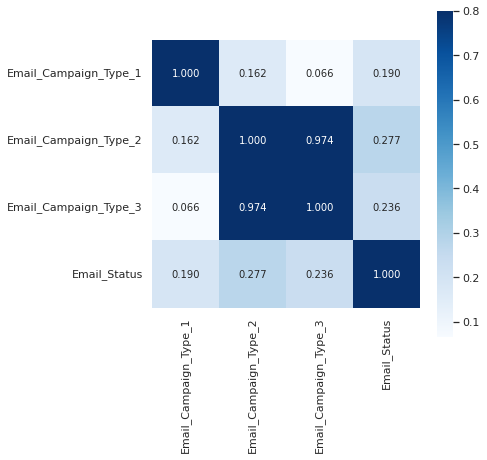

In [286]:
# find the correlation between encoded features & Sales
corr_mat = campaign_df.loc[:, ['Email_Campaign_Type_1', 'Email_Campaign_Type_2', 
                               'Email_Campaign_Type_3', 'Email_Status']].corr().abs()
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corr_mat, annot = True, fmt='.3f', annot_kws={'size': 10},  vmax=.8, square=True, cmap="Blues");

Email_Campaign_Type_1 has the least correlation to Sales. So, it is removed along with Email_Type_2 and Email_Source_Type_2.

In [287]:
# drop Email_Campaign_Type_1
campaign_df.drop(['Email_Type_2', 'Email_Source_Type_2', 'Email_Campaign_Type_1'], axis=1, inplace=True)

In [288]:
# exploring the head of the dataframe
campaign_df.head()

,Subject_Hotness_Score,Total_Past_Communications,Word_Count,Email_Status,Total_Links_Images,Email_Type_1,Email_Source_Type_1,Email_Campaign_Type_2,Email_Campaign_Type_3
0,1.483240,33,440,0,2.079442,1,0,1,0
1,1.449138,15,504,0,1.609438,0,1,1,0
2,0.316228,36,962,1,1.609438,0,1,0,1
3,1.732051,25,610,0,2.772589,1,0,1,0
4,0.000000,18,947,0,1.386294,1,0,0,1


# Modelling